In [2]:
from sklearn.cluster import KMeans
import tqdm
import cv2
import numpy as np

In [3]:
import sys
sys.path.append("../")

In [4]:
from data.eft_dataset import EFTDataset

dataset = EFTDataset(datasets=['coco14'],is_train=False)

In [26]:
angles = []
for i in range(24):
    angles.append([])

In [27]:
for i in tqdm.tqdm(range(1000)):
    pose = dataset[i]['pose']
    for j in range(24):
        angles[j].append(cv2.Rodrigues(pose[j].numpy())[0])

100%|██████████| 1000/1000 [00:20<00:00, 49.63it/s]


In [32]:
an0 = np.concatenate(angles[0],axis=-1)

In [33]:
an0.shape

(3, 1000)

In [37]:
kmeans_list = []
for j in range(24):
    km = KMeans(n_clusters=20,n_init='auto')
    km.fit(np.concatenate(angles[j],axis=-1).T)
    kmeans_list.append(km)

In [40]:
an0_predictions = kmeans_list[0].predict(np.concatenate(angles[0],axis=-1).T)

In [43]:
an0_quantized = kmeans_list[0].cluster_centers_[an0_predictions]

In [44]:
an0_quantized.shape

(1000, 3)

### Quantize mean pose and visualize

In [5]:
from data.utils import load_mean_parameters,rot6d_to_rotmat
import config
from models.smpl import get_smpl_model
from data.display_utils import display_model
import torch

In [6]:
theta_mean = load_mean_parameters(config.SMPL_MEAN_PARAMS,rot6d=True)#load the real theta_mean
smpl = get_smpl_model()

In [7]:
pose = theta_mean[:,:144]
shape = theta_mean[:,144:154]

In [8]:
pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3)

In [9]:
output = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)

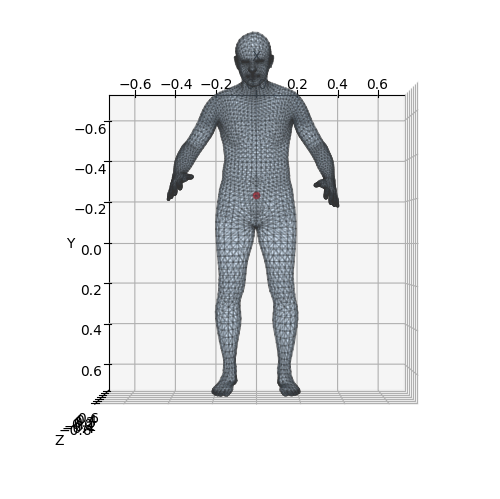

In [15]:
ax = display_model(
            {'verts': output.vertices.cpu().detach(),
             'joints': output.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False)
ax.view_init(elev=-90,azim=-90)

In [71]:
quant_mat = []
for j in range(24):
    aa = cv2.Rodrigues(pose_mat[0,j].numpy())[0].T
    aa_q = kmeans_list[j].cluster_centers_[kmeans_list[j].predict(aa)]
    quant_mat.append(cv2.Rodrigues(aa_q)[0])

In [74]:
pose_q_mat = torch.from_numpy(np.stack(quant_mat,axis=0)).unsqueeze(0)

In [75]:
pose_q_mat.shape

torch.Size([1, 24, 3, 3])

In [76]:
output = smpl(global_orient=pose_q_mat[:,:1,:],body_pose=pose_q_mat[:,1:,:],betas=shape,pose2rot=False)

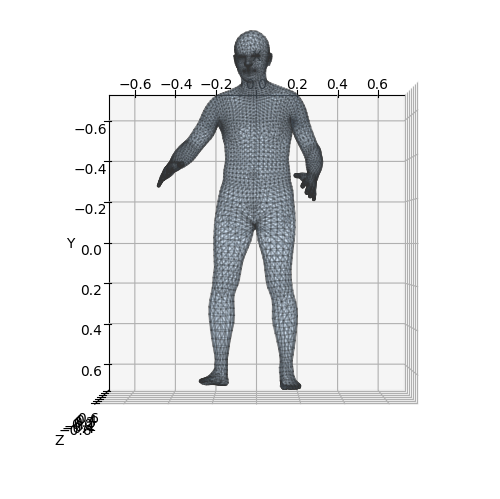

In [77]:

ax = display_model(
            {'verts': output.vertices.cpu().detach(),
             'joints': output.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False)
ax.view_init(elev=-90,azim=-90)